In [1]:
# --- MLP Sine Approx (Keras) ---
# Requiere: tensorflow, numpy, matplotlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# 1) Dataset proporcionado
x_train = np.linspace(0, np.pi*2, 20)            # 20 puntos en [0, 2π]
y_train = np.sin(x_train).astype(np.float32)

# (Opcional) Valida en una malla más densa para evaluar generalización
x_val = np.linspace(0, 2*np.pi, 200)
y_val = np.sin(x_val).astype(np.float32)

In [3]:
# 2) ¡IMPORTANTÍSIMO! NORMALIZACIÓN IGUAL QUE EN ARDUINO
# Usaremos x_norm = x / π tanto en entrenamiento como en Arduino.
def normalize(x):
    return x / np.pi

x_train_norm = normalize(x_train).astype(np.float32).reshape(-1, 1)
x_val_norm   = normalize(x_val).astype(np.float32).reshape(-1, 1)

In [4]:
# 3) MLP 1 -> 16 -> 1 con tanh (salida lineal)
H = 16
model = keras.Sequential([
    layers.Input(shape=(1,)),
    layers.Dense(H, activation='tanh', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
    layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='zeros')
])

# Optimizador y entrenamiento
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='mse')
hist = model.fit(x_train_norm, y_train,
                 epochs=5000, verbose=0)

In [5]:

# 4) Evaluación rápida
y_pred = model.predict(x_val_norm, verbose=0).flatten()
mse = np.mean((y_pred - y_val)**2)
print(f"MSE en malla [0,2π] (200 pts): {mse:.6f}")

MSE en malla [0,2π] (200 pts): 0.000011


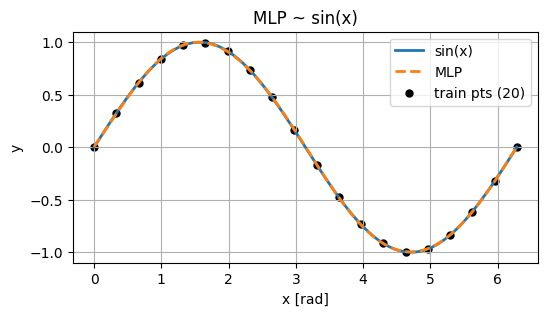

In [6]:
# 5) Visualización
plt.figure(figsize=(6,3))
plt.plot(x_val, y_val, label='sin(x)', linewidth=2)
plt.plot(x_val, y_pred, '--', label='MLP', linewidth=2)
plt.scatter(x_train, y_train, color='k', s=25, label='train pts (20)')
plt.legend(); plt.grid(True); plt.title("MLP ~ sin(x)")
plt.xlabel("x [rad]"); plt.ylabel("y")
plt.show()

In [7]:
# 6) EXTRAER PESOS en formato C para Arduino
#   Capa oculta:    W0: (1,H), b0: (H,)
#   Capa de salida: W1: (H,1), b1: (1,)
W0_keras, b0_keras = model.layers[0].get_weights()  # W0_keras shape (1,H)
W1_keras, b1_keras = model.layers[1].get_weights()  # W1_keras shape (H,1)

In [8]:
# Flatten a 1D para pegar fácil
W0 = W0_keras.flatten()           # (H,)
b0 = b0_keras.flatten()           # (H,)
W1 = W1_keras.flatten()           # (H,)
b1 = float(b1_keras.flatten()[0]) # escalar

def to_c_array(name, arr, fmt="{:.6f}f"):
    s = f"static const float {name}[{len(arr)}] = {{ "
    s += ", ".join(fmt.format(x) for x in arr)
    s += " };"
    return s

print("\n--- COPIAR A ARDUINO (modo inferencia) ---")
print(f"#define H {H}")
print(to_c_array("W0", W0))
print(to_c_array("b0", b0))
print(to_c_array("W1", W1))
print(f"static const float b1 = {b1:.6f}f;")
print("--- FIN ---\n")


--- COPIAR A ARDUINO (modo inferencia) ---
#define H 16
static const float W0[16] = { -2.242205f, 1.080316f, -0.524318f, 0.401677f, -0.508689f, 0.681906f, -0.396343f, 1.134409f, -0.387459f, -0.396157f, -0.012345f, -0.956068f, 1.914582f, -2.229915f, 0.396376f, -1.138070f };
static const float b0[16] = { 0.283488f, -0.545148f, -0.023614f, -0.187147f, 0.090871f, 0.028695f, 0.156926f, -0.853016f, 0.109525f, 0.085076f, 0.057581f, 0.321676f, -3.775601f, 2.402312f, -0.051009f, 0.889783f };
static const float W1[16] = { -1.741876f, -0.531684f, -0.100296f, 0.581034f, -0.353649f, -0.364444f, -0.635743f, -0.822812f, -0.344030f, -0.581307f, -0.007802f, 0.234926f, 1.651513f, 1.075741f, 0.657285f, 0.968343f };
static const float b1 = -0.152316f;
--- FIN ---



In [9]:
# Sanity check numérico: comparar una tabla de nn(x) vs sin(x) en algunos puntos
test_x = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 3*np.pi/2], dtype=np.float32)
test_pred = model.predict(normalize(test_x).reshape(-1,1), verbose=0).flatten()
for tx, yp in zip(test_x, test_pred):
    print(f"x={tx:.5f}  nn={yp:+.6f}  sin={np.sin(tx):+.6f}  err={yp-np.sin(tx):+.6f}")

x=0.00000  nn=+0.003722  sin=+0.000000  err=+0.003722
x=0.78540  nn=+0.708524  sin=+0.707107  err=+0.001417
x=1.57080  nn=+0.999722  sin=+1.000000  err=-0.000278
x=2.35619  nn=+0.704886  sin=+0.707107  err=-0.002221
x=3.14159  nn=+0.004237  sin=-0.000000  err=+0.004237
x=4.71239  nn=-0.997160  sin=-1.000000  err=+0.002840
